# To-Do

1. Folder with documents
2. Mathematical formula for n_top_keywords  (Done)
3. Exclude some specific words from the list (Done)

# 1. Install Libraries

In [11]:
# !pip install virtualenv
# !virtualenv myenv
# !source myenv/bin/activate
# !pip install pandas==1.4.3 numpy==1.23.5
#!pip install PyPDF2
# !pip install scikit-learn
# !pip install sentence-transformers
#!pip install nltk
#!pip install PyPDF2
#!pip install scikit-learn
#!pip install sentence-transformers
#!pip install wordcloud

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\HomePC\AppData\Roaming\nltk_data

True

# 2. Import Dependecies

In [12]:
import pandas as pd
import numpy as np
import PyPDF2
import re
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HomePC\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# 3. Helper Functions

In [ ]:
########## Extract and Clean Text ##########
def extract_text_from_pdf(file_path, words_to_exclude):
    # Extract text using PyPDF2
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = '' #e ruan ne nje string textin qe do te ekstraktohet nga pdf
        for page in reader.pages:
            text += page.extract_text() + '\n'

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation)) 

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove non-alphabetic characters and convert to lowercase
    tokens = [token.lower() for token in tokens if token.isalpha()]  #isalpha() kthen True nese tokeni eshte shkronje

    # Remove stop words
    stop_words = set(stopwords.words('english')) #fshin fjalite qe nuk kane kuptim ne
    stop_words = stop_words.union(words_to_exclude) #fshin edhe fjalite qe ne kemi ekstraktuar me pare
    tokens = [token for token in tokens if token not in stop_words] #fshin fjalite qe nuk kane kuptim ne anglisht

    # Remove words with length less than 3
    tokens = [token for token in tokens if len(token) >= 3] #fshin fjalite qe kane me pak se 3 shkronja

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer() #kthen fjalet ne forme te thjeshtuar 
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #kthen fjalet ne forme te thjeshtuar duke i hequr shkronjat e fundit

    # Join the tokens back into a string
    cleaned_text = ' '.join(tokens)

    return cleaned_text, tokens


########## Generate Top Key Words ##########
def get_top_keywords(text, n_top_key_words):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([text])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    sorted_indices = np.argsort(tfidf_matrix.toarray()).flatten()[::-1][:n_top_key_words]
    top_keywords = [feature_names[i] for i in sorted_indices]
    tfidf_weights = tfidf_matrix.toarray().flatten()[sorted_indices]

    # Calculate normalized weights
    normalized_weights = tfidf_weights / np.sum(tfidf_weights)

    return top_keywords, normalized_weights


########## Generate Embeddings ##########
def generate_bert_embedding(text):
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    embedding = model.encode([text])[0]  # Get the first (and only) embedding
    return embedding

########## Generate Weighted Sum Vector ##########
def generate_vector(embeddings, weights):
    weighted_embeddings = np.array([emb * w for emb, w in zip(embeddings, weights)])
    vector = np.sum(weighted_embeddings, axis=0)
    return vector.flatten()  # Ensure 1-D output

########## Calculate Cosine Similarity ##########

def calculate_cosine_similarity(vector1, vector2):
    return 1 - cosine(vector1, vector2)


########## Create a DataFrame with Similarities ##########
def generate_similarity_dataframe(pdf_vector, category_vectors, category_names, path_name):
    data = {path_name: []}
    for vector, category in zip(category_vectors, category_names):
        similarity = calculate_cosine_similarity(pdf_vector, vector)
        data[path_name].append(similarity)
    df = pd.DataFrame(data, index=category_names)
    return df

########## Main Function ##########
def process_pdf(file_path, categories):
    # Extract and clean text
    text, tokens = extract_text_from_pdf(file_path, words_to_exclude)

    # Generate number of key words based on length of text
    n_top_key_words = int(0.0002*len(tokens))
    if n_top_key_words < 1:
        n_top_key_words = 1

    # Get keywords and embeddings
    top_keywords, weights = get_top_keywords(text, n_top_key_words)
    keyword_embeddings = [generate_bert_embedding(keyword) for keyword in top_keywords]
    pdf_vector = generate_vector(keyword_embeddings, weights)

    # Get category embeddings
    category_embeddings = [generate_bert_embedding(category).flatten() for category in categories]

    # Generate similarity dataframe
    df = generate_similarity_dataframe(pdf_vector, category_embeddings, categories, file_path) 
    df = df.sort_values(df.columns[0], ascending=False)     


########## Vizualization Part ##########
    wordcloud = WordCloud(width = 1000, height = 500).generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("your_file_name"+".png", bbox_inches='tight')
    plt.show()
    plt.close()
    return df

# 4. Call the Main Function

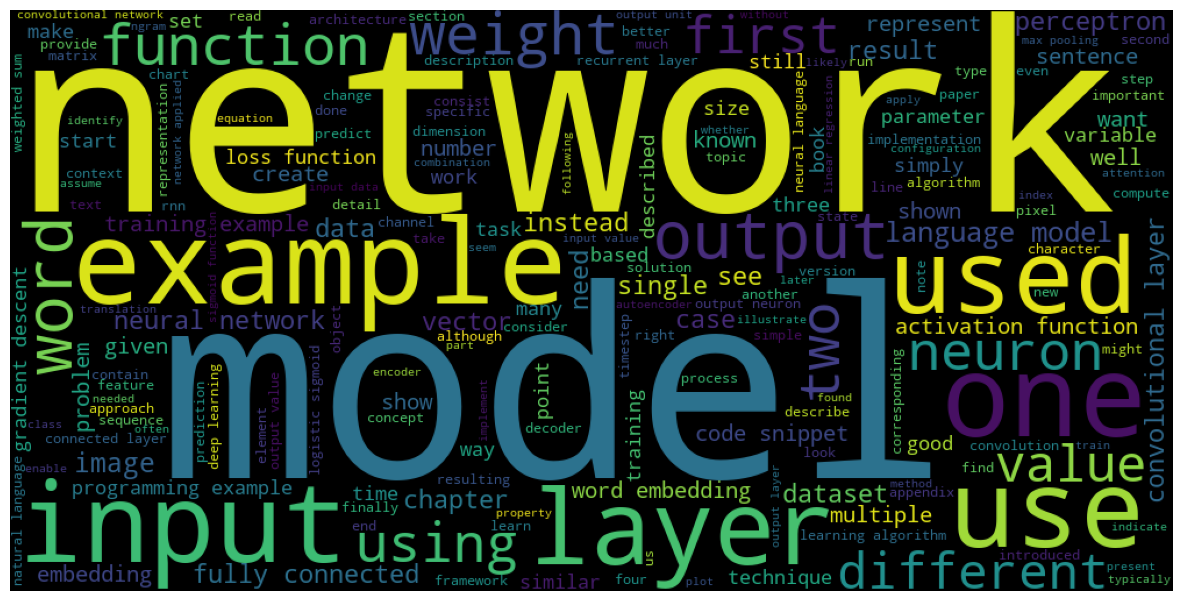

,Deep_learning_book.pdf
model,0.943635
layer,0.892991
energy,0.884970
neuron,0.811941
technology,0.798388


In [16]:

pdf_file = 'Deep_learning_book.pdf'
words_to_exclude = {'table','figure','page'}
category_list = ['energy', 'train', 'technology',
                 'model','deep learning',
                'data science','neuron','layer']

lower_threshold = 0.75

result_df = process_pdf(pdf_file, category_list)
result_df = result_df[result_df[pdf_file]>lower_threshold]
result_df

In [22]:
pdf_file = 'Deep_learning_book.pdf'
words_to_exclude = {'table','figure','page', 'two', 'example'}
text, tokens = extract_text_from_pdf(pdf_file, words_to_exclude)


In [23]:
text

'learning deep learning intentionally left blank learning deep learning theory practice neural network computer vision natural language processing transformer using tensorflow magnus ekman boston columbus new york san francisco amsterdam cape town dubai london madrid milan munich paris montreal toronto delhi mexico city são paulo sydney hong kong seoul singapore taipei tokyo many designation used manufacturer seller distinguish product claimed trademark designation appear book publisher aware trademark claim designation printed initial capital letter capital author publisher taken care preparation book make expressed implied warranty kind assume responsibility error omission liability assumed incidental consequential damage connection arising use information program contained herein nvidia make warranty representation technique described herein free intellectual property claim reader assumes risk claim based use technique information buying title bulk quantity special sale opportunity 

In [24]:
n_top_key_words = int(0.0002*len(tokens))
top_keywords, weights = get_top_keywords(text, n_top_key_words)

In [25]:
weights

array([0.09567884, 0.08545795, 0.08489013, 0.06603827, 0.06268809,
       0.06183635, 0.06007609, 0.04173528, 0.04116745, 0.0400318 ,
       0.03770371, 0.03668162, 0.03429675, 0.0341264 , 0.03372892,
       0.03344501, 0.03202544, 0.03077622, 0.03020839, 0.02873204,
       0.02867526])

In [26]:
top_keywords

['network',
 'layer',
 'model',
 'input',
 'word',
 'function',
 'output',
 'neuron',
 'weight',
 'training',
 'learning',
 'image',
 'one',
 'vector',
 'value',
 'use',
 'chapter',
 'data',
 'number',
 'language',
 'used']

In [ ]:
pdf_vector = generate_vector([generate_bert_embedding(keyword) for keyword in top_keywords], weights)

KeyboardInterrupt: 